In [1]:
import sys
sys.path.append("Methods/EWC/old")

In [2]:
from lib.abstract_torch import get_device, get_optimizer, get_loss
from lib.benchmark_generator import PermutedMNIST
from lib.models import ANN
from lib.train import train
from lib.test import test
from lib.visualize import vizualize_loss_hists, visualize_accs_matrix, visualize_avg_acc_curve

import os
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from avalanche.training.supervised import EWC
from avalanche.training.plugins import EWCPlugin
from avalanche.evaluation.metrics import accuracy_metrics, loss_metrics, forgetting_metrics
from avalanche.logging import InteractiveLogger
from avalanche.training.plugins import EvaluationPlugin

/home/mathis/miniconda3/envs/.jax_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
path = os.path.dirname(os.path.abspath("__file__"))
data_path = path + "/data"

In [4]:
device = get_device(1)

## Set parameters

In [5]:
# Benchmark parameter
num_tasks = 5
train_percentage = 0.5

# EWC parameter
ewc_lambda = 400

# Data parameter
batch_size=128

# Network Architecture
num_inputs = 28*28
num_hidden_root = 1000
num_outputs = 10

# Train parameters
loss_name = "CE"
optimizer_name = "Adam"

# Hyperparameters
num_epochs = 3
lr = 1e-3

## Reproducibility

In [6]:
random_seed = 88

## Get p-MNIST benchmark

In [7]:
benchmark = PermutedMNIST(n_experiences=num_tasks, train_percentage=train_percentage, difficulty="hard", seed=random_seed)

In [8]:
import torch

In [9]:
test_loaders_list = []
for test_experience in benchmark.test_stream :
        print(id(test_experience.dataset))
        test_dataset = test_experience.dataset
        test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True)
        test_loaders_list.append(test_data_loader)

125832328464096
125832328464672
125832328465248
125832328465824
125832328466400


In [10]:
train_loaders_list = []
for test_experience in benchmark.train_stream :
        print(id(test_experience.dataset))
        test_dataset = test_experience.dataset
        test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True)
        train_loaders_list.append(test_data_loader)

125832328406384
125832328410512
125832328411472
125832447621744
125832328463520


## Define model

In [11]:
model = ANN(num_inputs, num_hidden_root, num_outputs, random_seed).to(device)

## Train with EWC

In [12]:
optimizer = get_optimizer(optimizer_name, model)

In [13]:
eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True, trained_experience = True),
    loggers=[InteractiveLogger()]
)

ewc = EWC(
    model, optimizer, criterion=get_loss(loss_name), ewc_lambda=ewc_lambda,
    train_mb_size=batch_size, train_epochs=num_epochs, eval_mb_size=batch_size, eval_every=-1, #evaluator=eval_plugin,
    device=device
)

print((ewc.plugins[0].compute_importances(model=model,
                                       criterion=get_loss(loss_name),
                                       optimizer=optimizer,
                                       dataset=experience.dataset,
                                       device=device,
                                       batch_size=128)["fc1.weight"].data> 1e-6).sum())

In [14]:
experience = benchmark.train_stream[0]
ewc.plugins[0].compute_importances(model=model,
                                       criterion=get_loss(loss_name),
                                       optimizer=optimizer,
                                       dataset=experience.dataset,
                                       device=device,
                                       batch_size=128)["fc1.weight"].data

tensor([[8.0785e-08, 1.5004e-07, 4.1475e-07,  ..., 8.0528e-08, 9.3490e-07,
         1.5463e-07],
        [1.0948e-07, 2.3026e-07, 4.8135e-07,  ..., 1.0908e-07, 9.6608e-07,
         3.4684e-07],
        [1.1057e-07, 5.9118e-07, 4.5488e-07,  ..., 1.0964e-07, 1.4473e-06,
         3.0306e-07],
        ...,
        [5.3860e-08, 2.4493e-07, 1.8375e-07,  ..., 5.3403e-08, 7.0856e-07,
         7.2781e-08],
        [4.7135e-08, 2.4047e-07, 3.2157e-07,  ..., 4.7001e-08, 4.3455e-07,
         9.4483e-08],
        [1.3662e-07, 4.5235e-07, 6.3668e-07,  ..., 1.3597e-07, 1.8995e-06,
         1.9405e-07]], device='cuda:1')

In [15]:
ewc.plugins[0].importances

defaultdict(dict, {})

In [16]:
test_accs_matrix = np.zeros((num_tasks, num_tasks))
train_accs_matrix = np.zeros((num_tasks, num_tasks))

for task_number, train_experience, test_experience in zip(list(range(num_tasks)), benchmark.train_stream, benchmark.test_stream) :
    ewc.train(train_experience)
    for j in range(num_tasks) :
        test_accs_matrix[task_number,j] = round(test(model, test_loaders_list[j], 128, device),2)
        train_accs_matrix[task_number,j] = round(test(model, train_loaders_list[j], 128, device),2)

-- >> Start of training phase << --
0it [00:00, ?it/s]

100%|██████████| 235/235 [00:03<00:00, 69.58it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.4232
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8761
100%|██████████| 235/235 [00:03<00:00, 72.21it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.1318
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9596
100%|██████████| 235/235 [00:03<00:00, 68.43it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.1029
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9672
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 235/235 [00:03<00:00, 68.02it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.5370
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8630
100%|██████████| 235/235 [00:03<00:00, 68.12it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.2356
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9516
100%|██████████| 235/235 [00:03<00:00, 68.03i

## Visualize results

In [17]:
test_accs_matrix

array([[95.68,  8.05,  6.25, 11.79,  9.96],
       [90.67, 96.  ,  9.11, 10.57, 10.2 ],
       [85.29, 86.82, 95.98,  6.98,  9.03],
       [83.19, 80.88, 81.55, 95.13, 11.88],
       [79.41, 81.8 , 78.97, 89.06, 95.04]])

In [18]:
train_accs_matrix

array([[97.02,  8.72,  6.29, 12.25,  9.82],
       [92.23, 97.46,  9.1 , 10.4 , 10.83],
       [86.35, 87.06, 97.43,  7.39,  9.34],
       [83.76, 80.61, 81.52, 96.86, 12.4 ],
       [80.02, 81.13, 78.89, 89.87, 96.93]])

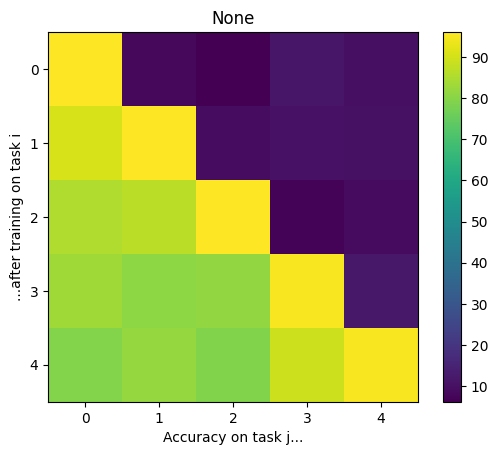

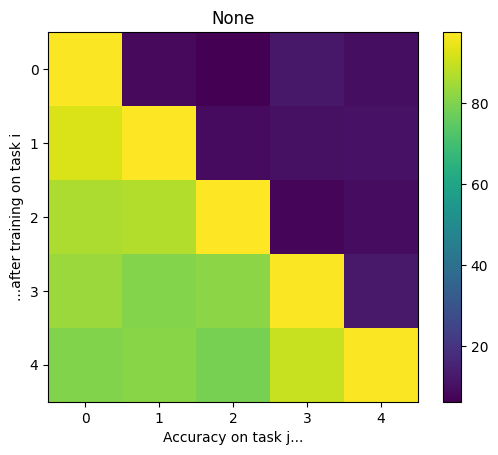

In [19]:
visualize_accs_matrix(test_accs_matrix)
visualize_accs_matrix(train_accs_matrix)

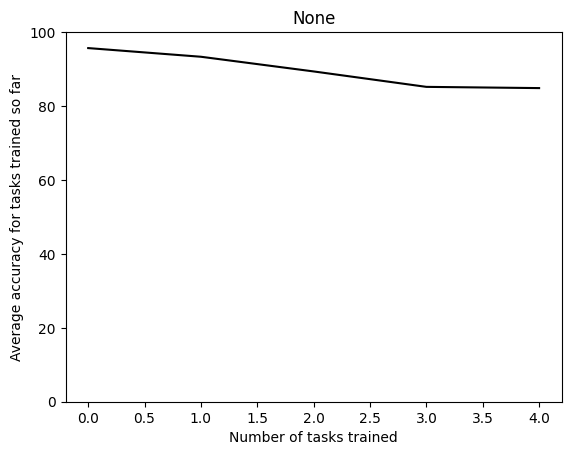

In [20]:
visualize_avg_acc_curve(test_accs_matrix)

In [21]:
model = ANN(num_inputs, num_hidden_root, num_outputs, random_seed).to(device)
optimizer = get_optimizer(optimizer_name, model)

In [22]:
eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True, trained_experience = True),
    loggers=[InteractiveLogger()]
)

ewc = EWC(
    model, optimizer, criterion=get_loss(loss_name), ewc_lambda=ewc_lambda,
    train_mb_size=batch_size, train_epochs=num_epochs, eval_mb_size=batch_size, evaluator=eval_plugin,
    device=device
)

In [23]:
ewc.plugins[0].importances[0]
ewc.plugins[3].train_exp_counter

0

In [24]:
#ewc.plugins[0].importances[0] = sto[0]
#ewc.plugins[3].train_exp_counter = 1

In [25]:
ewc.plugins[0].importances[0]
ewc.plugins[3].train_exp_counter

0

In [26]:
ewc = EWC(
        model=model, 
        optimizer=get_optimizer(optimizer_name, model),
        criterion=get_loss(loss_name),
        ewc_lambda=0,
        train_mb_size=batch_size,
        train_epochs=0, 
        eval_every=-1,
        device=device
    )

In [27]:
id(ewc.model)

125831742332928

In [28]:
ewc.train_epochs

0

In [29]:
sto_ewc = None
test_accs_matrix = np.zeros((num_tasks, num_tasks))
for task_number, train_experience in zip(list(range(num_tasks)), benchmark.train_stream) :
    # Define the EWC Plugin
    if task_number != 0:
        ewc = sto_ewc
    else :
        ewc = EWC(
        model, optimizer, criterion=get_loss(loss_name), ewc_lambda=ewc_lambda,
        train_mb_size=batch_size, train_epochs=num_epochs, eval_mb_size=batch_size, evaluator=eval_plugin,
        device=device
        )
    
    if task_number == 2:
        ewc.plugins[0].ewc_lambda = 4000000

    ewc.train(train_experience)

    for j in range(num_tasks) :
        test_accs_matrix[task_number,j] = round(test(model, test_loaders_list[j], 128, device),2)
    sto_ewc = ewc

-- >> Start of training phase << --
  1%|          | 2/235 [00:00<00:12, 19.26it/s]

100%|██████████| 235/235 [00:03<00:00, 70.12it/s]
Epoch 0 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8626
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.9792
100%|██████████| 235/235 [00:03<00:00, 69.81it/s]
Epoch 1 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9588
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.9792
100%|██████████| 235/235 [00:03<00:00, 68.05it/s]
Epoch 2 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9684
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.9792
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 235/235 [00:03<00:00, 67.41it/s]
Epoch 0 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8712
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.9167
100%|██████████| 235/235 [00:03<00:00, 66.81it/s]
Epoch 1 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9516
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.9792
100%|██████████| 235/235 [00:03<00:00, 6

## Visualize results

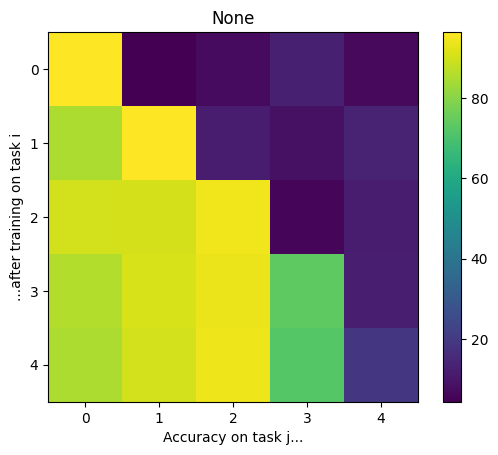

In [30]:
visualize_accs_matrix(test_accs_matrix)

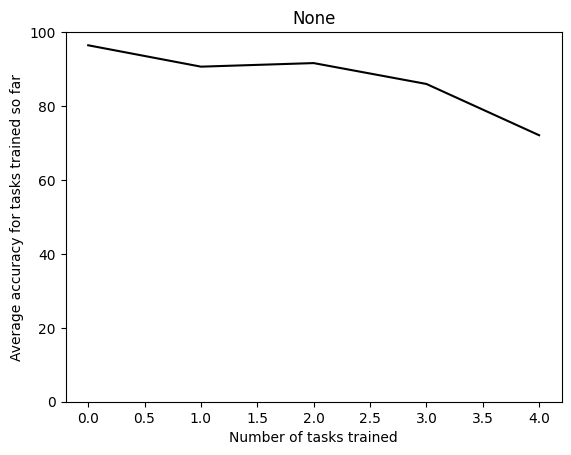

In [31]:
visualize_avg_acc_curve(test_accs_matrix)